# Intro
This notebook goes over a semi-supervised VAE for predicting MNIST digits

In [1]:
# general imports
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model


import seaborn as sns
from sklearn.manifold import TSNE


# I disable eager execution
#https://stackoverflow.com/questions/65366442/cannot-convert-a-symbolic-keras-input-output-to-a-numpy-array-typeerror-when-usi
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# import the our code
import sys
import time

import random

random.seed(1000)


# **Import and Pre-process data**
Import + reshape the MNIST data

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

print("\nfirst 5 elements of y_train\n")
print(y_train[0:5])

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)

first 5 elements of y_train

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [3]:
# range of values in X_train
np.unique(X_train)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

Y_train value: 5


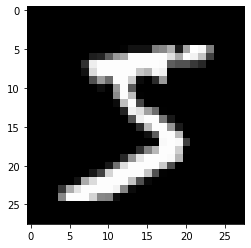

In [4]:
print(f"Y_train value: {Y_train[0]}")
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray)
plt.show()

Y_train value: 0


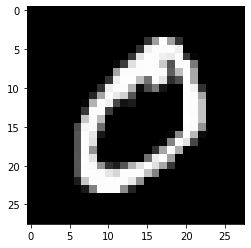

In [5]:
print(f"Y_train value: {Y_train[1]}")
plt.imshow(X_train[1].reshape(28, 28), cmap = plt.cm.gray)
plt.show()

# **Model Definition**

## Hyperparameters

In [6]:
batch_size = 50
n_epoch = 50

# 28*28 = 784
# the network dimensions are 784 > 512 > 10 < 512 < 784
n_z = 10 # latent space size
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

class_dim1 = 512
class_dim2 = 256

activ = 'relu' ### why?? vs. sigmoid? what if I scaled my data?
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) 

n_x = X_train.shape[1]
n_y = y_train.shape[1]

print(f"length of X {n_x} and length of y {n_y}")


length of X 784 and length of y 10


## Encoder

In [7]:
# declare the Keras tensor we will use as input to the encoder
_X = Input(batch_shape=(batch_size, n_x))
_Y = Input(batch_shape=(batch_size, n_y))

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(_X)

# now from the hidden layer, you get the mu and sigma for 
# the latent space
mu = Dense(n_z, activation='linear', name = "mu")(encoder_h)
l_sigma = Dense(n_z, activation='linear', name = "sigma")(encoder_h)



## Latent Space + Classifier

Classifier uses z to do prediction.
This is great when we have limited labeled data, because we can get a good representation to train the classifier on.

In [8]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name="z_samp")([mu, l_sigma])

#defining the architecture of the classifier
class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(z)
classifier_h2 = class_hidden2(classifier_h1)
_Y_cls = class_out(classifier_h2)




## Decoder

In [9]:
# set up decoder network
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_out = Dense(decoder_out_dim, activation=activ, name = "decoder_out") # sigmoid


# this is the decoder
d_h1 = decoder_hidden(z)
d_out = decoder_out(d_h1)


## Loss

In [10]:
beta = 1
def labeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def unlabeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)

    return recon + kl

def KL_loss(y_true, y_pred):
	return(beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def cls_loss(y_true, y_pred, N=1000):
    return K.categorical_crossentropy(y_true, y_pred)*1000


## Make the computational graph

In [11]:
ss_vae_lab = Model([_X, _Y], [d_out, _Y_cls])

encoder_lab = Model(_X, [mu, z])

ss_vae_unlab = Model(_X, d_out)

classifier = Model(_X, _Y_cls)


ss_vae_lab.compile(optimizer=optim, loss=[labeled_vae_loss, cls_loss], metrics = [KL_loss, recon_loss])
ss_vae_unlab.compile(optimizer=optim, loss=unlabeled_vae_loss, metrics = [KL_loss, recon_loss])


ss_vae_lab_init_wts = ss_vae_lab.get_weights()
ss_vae_unlab_init_wts = ss_vae_unlab.get_weights()
classifier_init_wts = classifier.get_weights()
encoder_init_wts = encoder_lab.get_weights()



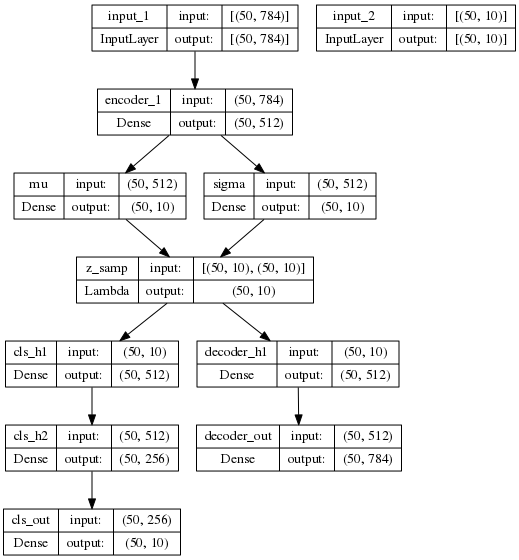

In [12]:
display(plot_model(ss_vae_lab, show_layer_names=True, show_shapes=True, dpi=72))

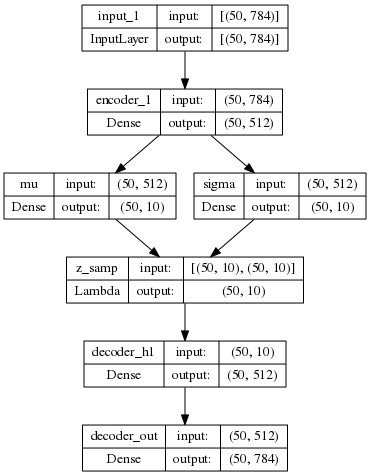

In [13]:
display(plot_model(ss_vae_unlab, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

In [14]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    assert len(X_unlabeled) % len(X_labeled) == 0, \
            (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = ss_vae_lab.train_on_batch([X_labeled[index_range], y_labeled[index_range]], 
                                                [X_labeled[index_range], y_labeled[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [ss_vae_unlab.train_on_batch(X_unlabeled[index_range],  X_unlabeled[index_range])]
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# Experiments

Now lets train and evaluate the model.
First we train with 50 labeled and 50 unlabeled samples.
We will then increase the number of unlabeled samples from 50 to 5000.
We assume that increasing the number of unlabeled samples should result in an increase in accuracy, even though the number of labeled samples is constant.

In [15]:
sample_size = 100
num_unlabeled = 100
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

#df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
#display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
#df.plot(figsize=(8, 6))

Fitting with sample_size: 100


<ipython-input-14-86a35fe555c7>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs):


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-86a35fe555c7>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  with tnrange(batches, leave=False) as pbar:


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Elapsed:  3.2398626804351807


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 * Accuracy: 71.8 %
 * Fit time elapsed: 3.5s


In [24]:

ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)
encoder_lab.set_weights(encoder_init_wts)


sample_size = 100
num_unlabeled = 500
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})


Fitting with sample_size: 100


<ipython-input-14-86a35fe555c7>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs):


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-86a35fe555c7>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  with tnrange(batches, leave=False) as pbar:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Elapsed:  7.361488342285156
 * Accuracy: 68.7 %
 * Fit time elapsed: 7.6s


In [17]:

ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)
encoder_lab.set_weights(encoder_init_wts)


sample_size = 100
num_unlabeled = 5000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})


Fitting with sample_size: 100


<ipython-input-14-86a35fe555c7>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs):


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-86a35fe555c7>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  with tnrange(batches, leave=False) as pbar:


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Elapsed:  67.59565210342407
 * Accuracy: 70.7 %
 * Fit time elapsed: 67.9s


In [18]:

ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)
encoder_lab.set_weights(encoder_init_wts)



sample_size = 100
num_unlabeled = 10000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset

history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})


Fitting with sample_size: 100


<ipython-input-14-86a35fe555c7>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs):


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-86a35fe555c7>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  with tnrange(batches, leave=False) as pbar:


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Elapsed:  134.30213594436646
 * Accuracy: 74.0 %
 * Fit time elapsed: 134.7s


# **Baseline Model**

To ensure that we are beating the baseline model, lets use the same amount if labeled data to see that we will not perform as well.

In [23]:
# baseline classifier


x_train = X_train
x_test = X_test


#choosing the sequential model
baseline_model = Sequential()

# defining the architecture of the model
# this has a similar number of parameters 
# but is still a good comparator
X_class = Input(shape=(n_x,))
baseline_model.add(X_class)
baseline_model.add(Dense(512, activation='relu'))
baseline_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
baseline_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

sample_size = 100
rand_idx = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]

#training the model
baseline_model.fit(X_train_subset, y_train_subset, epochs=n_epoch)

# get accuracy
y_pred = np.argmax(baseline_model.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

print(' * Accuracy: %.1f %%' % (100. * score))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 0s 605us/sample - loss: 2.1363 - accuracy: 0.3000
Epoch 2/50
100/100 [==============================] - 0s 78us/sample - loss: 1.2429 - accuracy: 0.7200
Epoch 3/50
100/100 [==============================] - 0s 79us/sample - loss: 0.8114 - accuracy: 0.8400
Epoch 4/50
100/100 [==============================] - 0s 77us/sample - loss: 0.5703 - accuracy: 0.8900
Epoch 5/50

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 * Accuracy: 69.0 %


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.085s...
[t-SNE] Computed neighbors for 60000 samples in 18.929s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

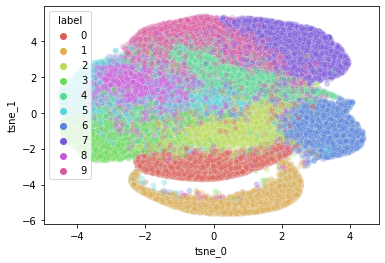

In [25]:
z_test = encoder_lab.predict(X_train)
encodings= np.asarray(z_test)
encodings = encodings[0]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Y_train

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

